Goal: Building Sentiment Analysis model. 

In [1]:
import numpy as np
import pandas as pd
import string
import spacy
from matplotlib.pyplot import imread
from wordcloud import WordCloud

df = pd.read_csv('emails.csv', error_bad_lines = False)
df

In [1]:
df = [x.strip() for x in df.text] #removes both the leading and trailing characters. .string does this trick for us.  
df = [x for x in df if x] # removes empty strings, b/c in python they are considered as False. 
#Basically, we are saing that if there is a word, return it, x will never equal empty space hence we will get ride of them.  

df[1:4]


In [ ]:
# part of speech tagging
nlp = spacy.load('en_core_web_sm') # this generates the NER, its pre built library

#lets extract on element from the df
one_review = df[3]
# now apply nlp to it.
apply_nlp = nlp(one_review)
#now display it:
spacy.displacy.render(apply_nlp, style='ent', jupyter=True)




Now extract nouns and verbs from this data.

In [ ]:
one_review 

'Subject: 4 color printing special  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  phone : ( 626 ) 338 - 8090 fax : ( 626 ) 338 - 8102 e - mail : ramsey @ goldengraphix . com  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  golden graphix & printing 5110 azusa canyon rd . irwindale , ca 91706 this e - mail message is an advertisement and / or solicitation .'

In [ ]:
#now extract the POS like nouns and verbs. 
for word in apply_nlp[0:30]:
    print(word, "-",word.pos_)

Subject - PROPN
: - PUNCT
4 - NUM
color - NOUN
printing - VERB
special - ADJ
  - SPACE
request - VERB
additional - ADJ
information - NOUN
now - ADV
! - PUNCT
click - VERB
here - ADV
  - SPACE
click - VERB
here - ADV
for - ADP
a - DET
printable - ADJ
version - NOUN
of - ADP
our - PRON
order - NOUN
form - NOUN
( - PUNCT
pdf - NOUN
format - NOUN
) - PUNCT
  - SPACE


In [ ]:
#now filter out nouns and verbs:
noun_verb = [i.text for i in apply_nlp if i.pos_ in ('NOUN','VERB')]
noun_verb

['color',
 'printing',
 'request',
 'information',
 'click',
 'click',
 'version',
 'order',
 'form',
 'pdf',
 'format',
 'phone',
 'fax',
 'e',
 'mail',
 'ramsey',
 'com',
 'request',
 'information',
 'click',
 'click',
 'version',
 'order',
 'form',
 'pdf',
 'format',
 'graphix',
 'printing',
 'e',
 'mail',
 'message',
 'advertisement',
 'solicitation']

Now count how many times these Nouns and or verbs have occured. 
So, we use CountVectorizer

In [ ]:
#Counting tokens again
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

f_t = cv.fit_transform(noun_verb)
# now lets count the words
sum_words = f_t.sum(axis=0).tolist()[0]
words_freq = [(words, sum_words[i]) for words, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda y: y[1], reverse = True)
wf_df = pd.DataFrame(words_freq)
wf_df.columns = ['Words', 'Frequency']

wf_df

,Words,Frequency
0,click,4
1,printing,2
2,request,2
3,information,2
4,version,2
5,order,2
6,form,2
7,pdf,2
8,format,2
9,mail,2


<AxesSubplot:title={'center':'Top Verbs and Nouns'}, xlabel='Words'>

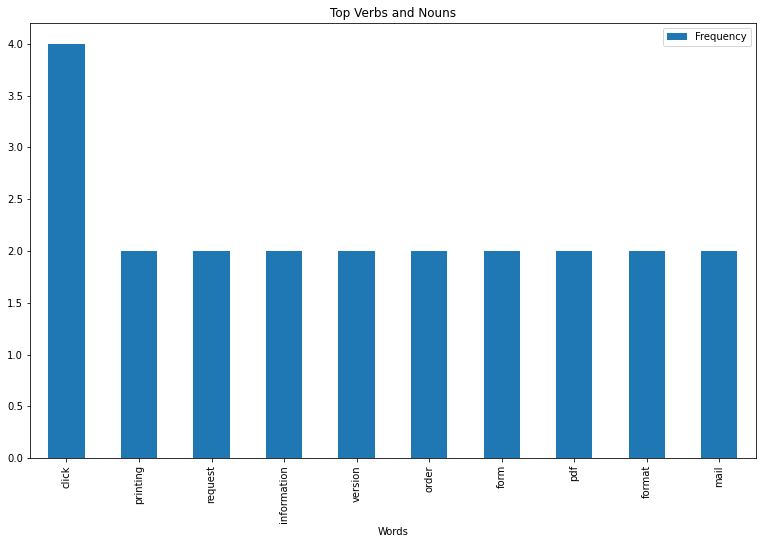

In [ ]:
wf_df[0:10].plot.bar(x='Words', figsize =(13,8), title='Top Verbs and Nouns')

In [ ]:
afinn = pd.read_csv('afinn.csv', sep =',', encoding = 'latin-1')
#afinn = afinn.reorder_levels
afinn

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
...,...,...
2472,yucky,-2
2473,yummy,3
2474,zealot,-2
2475,zealots,-2


In [ ]:
afinn.shape

(2477, 2)

In [ ]:
e_m = pd.read_csv('emails.csv', error_bad_lines = False)
list_form = [x.strip() for x in e_m.text]

list_form = [x for x in list_form if x]
print(list_form[2])

Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate .  this offer is being extended to you unconditionally and your credit is in no way a factor .  to take advantage of this limited time opportunity  all we ask is that you visit our website and complete  the 1 minute post approval form  look foward to hearing from you ,  dorcas pittman


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/navnoorsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk import tokenize
sentence_tokeninze = tokenize.sent_tokenize(" ".join(list_form))
sentence_tokeninze[2:7]

['here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image .',
 'convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure .',
 'promptness : you  will see logo drafts within three business days .',
 "affordability : your  marketing break - through shouldn ' t make gaps in your budget .",
 '100 % satisfaction  guaranteed : we provide unlimited amount of changes with no extra fees for you to  be surethat you will love the result of this collaboration .']

In [ ]:
sent_df = pd.DataFrame(sentence_tokeninze, columns= ['Sentences'])
sent_df.columns

Index(['Sentences'], dtype='object')

In [ ]:
#change the afinn var to a dictionary form with words as key and num representation as values 
afinn_scores_dic = afinn.set_index('word')['value'].to_dict()

In [ ]:
nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = afinn_scores_dic

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0) 
    return sent_score


In [ ]:
calculate_sentiment('happy')

3

In [ ]:
sent_df['sentiment_value'] = sent_df['Sentences'].apply(calculate_sentiment)

In [ ]:
#so we just got the sentiment value of each sentence. 
sent_df.head()


,Sentences,sentiment_value
0,Subject: naturally irresistible your corporate...,10
1,we do not promise that havinq ordered a iogo y...,9
2,here is the list of clear benefits : creative...,3
3,convenience : logo and stationery are provide...,1
4,promptness : you will see logo drafts within ...,0


In [ ]:
#here we sre counting the len of each word.
sent_df['word_count'] = sent_df['Sentences'].str.split().apply(len)
sent_df.sort_values(by='sentiment_value')

,Sentences,sentiment_value,word_count
92109,the bulletpoints are : balancing market risk ...,-23,88
57620,> > riskops ( tm ) incorporates a database of...,-16,62
103153,analysis in this week ' s analysis :   tak...,-16,68
50160,the november features race - based underwriti...,-15,75
62617,other promotions specialist to senior special...,-14,223
...,...,...,...
23590,_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ...,21,480
18285,* | to 48 6 - 04 c 20 p { % rand } > > sspl...,21,82
9608,included with your order : agent manual - all...,22,150
19779,"winning notice for category \ "" a \ "" winner ...",27,45


In [ ]:
sent_df.describe()

,sentiment_value,word_count
count,107176.000000,107176.000000
mean,0.565229,17.468510
std,1.612275,23.837369
min,-23.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,12.000000
75%,1.000000,23.000000
max,31.000000,1683.000000


In [ ]:
sent_df[sent_df['sentiment_value']<=0].head(6)

,Sentences,sentiment_value,word_count
4,promptness : you will see logo drafts within ...,0,12
5,affordability : your marketing break - throug...,0,16
8,.,0,1
9,.,0,1
11,72 fixed rate .,0,4
12,this offer is being extended to you unconditio...,0,18


In [ ]:
sent_df[sent_df['sentiment_value']>5].head(6)

,Sentences,sentiment_value,word_count
0,Subject: naturally irresistible your corporate...,10,44
1,we do not promise that havinq ordered a iogo y...,9,53
10,_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ...,9,172
27,"Subject: great nnews hello , welcome to medzo...",8,28
37,"with this in mind , it is with great excitemen...",6,17
55,"( otcbb : vnbl - news ) , a holding company s...",6,79


In [ ]:
sent_df

,Sentences,sentiment_value,word_count
0,Subject: naturally irresistible your corporate...,10,44
1,we do not promise that havinq ordered a iogo y...,9,53
2,here is the list of clear benefits : creative...,3,26
3,convenience : logo and stationery are provide...,1,29
4,promptness : you will see logo drafts within ...,0,12
...,...,...,...
107171,com todd @ epis .,0,5
107172,com > > - what ' s new - version 5 .,0,12
107173,2 information .,0,3
107174,doc - technical information aurora v 5 - 2 .,0,10


In [ ]:
#create index
sent_df['Index'] = range(0,len(sent_df))
sent_df 

,Sentences,sentiment_value,word_count,Index
0,Subject: naturally irresistible your corporate...,10,44,0
1,we do not promise that havinq ordered a iogo y...,9,53,1
2,here is the list of clear benefits : creative...,3,26,2
3,convenience : logo and stationery are provide...,1,29,3
4,promptness : you will see logo drafts within ...,0,12,4
...,...,...,...,...
107171,com todd @ epis .,0,5,107171
107172,com > > - what ' s new - version 5 .,0,12,107172
107173,2 information .,0,3,107173
107174,doc - technical information aurora v 5 - 2 .,0,10,107174


/Users/navnoorsingh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-10.0, 10.0)

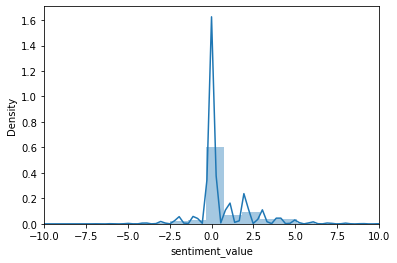

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(sent_df['sentiment_value'])
plt.xlim(-10,10)


<AxesSubplot:xlabel='Index', ylabel='sentiment_value'>

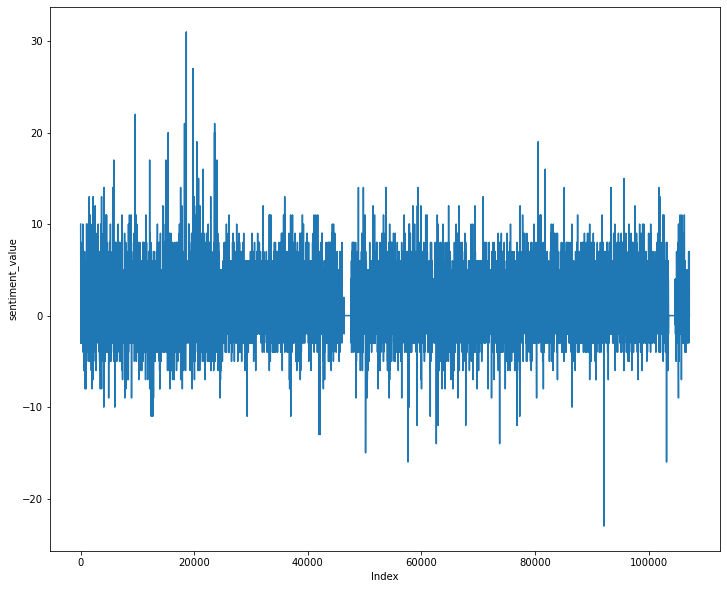

In [ ]:
plt.figure(figsize=(12,10))
sns.lineplot(x='Index', y='sentiment_value', data =sent_df)

<AxesSubplot:title={'center':'How sentiment relates to word count'}, xlabel='word_count', ylabel='sentiment_value'>

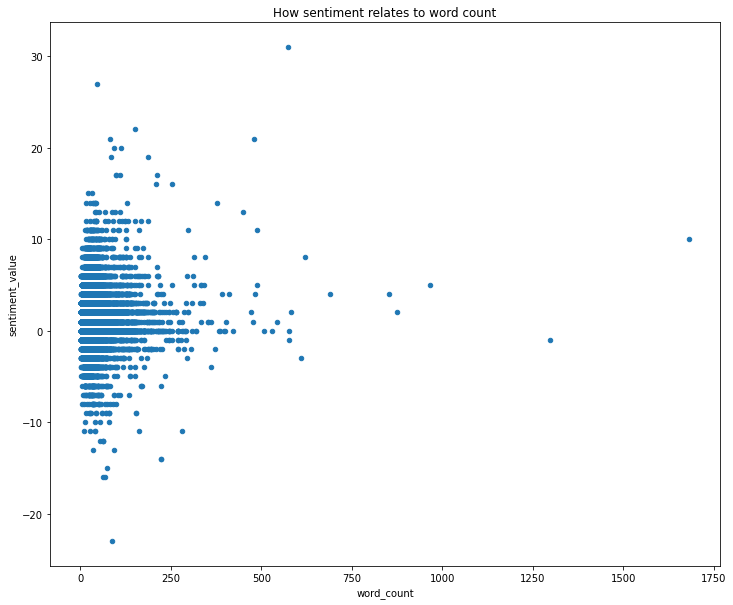

In [ ]:
sent_df.plot.scatter(x='word_count', y='sentiment_value', figsize =(12,10), title='How sentiment relates to word count')
